In [4]:
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
from IPython.display import display
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score

from keras import Input, Model
from keras.optimizers import Adam
from keras.models import Sequential
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau 
from keras.preprocessing.image import ImageDataGenerator
from keras.losses import sparse_categorical_crossentropy, binary_crossentropy
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, experimental, MaxPool2D, BatchNormalization

np.random.seed(42)
random.seed(42)

In [5]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print("User uploaded file {name} with length {length} bytes".format(
      name=fn, length=len(uploaded[fn])))
  
# Move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file kaggle.json with length 63 bytes


In [6]:
!kaggle datasets download "nipunarora8/age-gender-and-ethnicity-face-data-csv"

 87% 55.0M/63.2M [00:00<00:00, 119MB/s] 
100% 63.2M/63.2M [00:00<00:00, 108MB/s]


In [7]:
!unzip "/content/age-gender-and-ethnicity-face-data-csv.zip"

Archive:  /content/age-gender-and-ethnicity-face-data-csv.zip
  inflating: age_gender.csv          


In [8]:
df = pd.read_csv("/content/age_gender.csv")
df.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23705 entries, 0 to 23704
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        23705 non-null  int64 
 1   ethnicity  23705 non-null  int64 
 2   gender     23705 non-null  int64 
 3   img_name   23705 non-null  object
 4   pixels     23705 non-null  object
dtypes: int64(3), object(2)
memory usage: 926.1+ KB


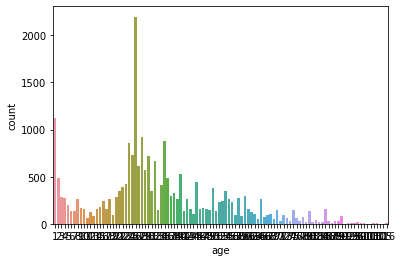

In [10]:
# Age distribution
sns.countplot(x="age", data=df)

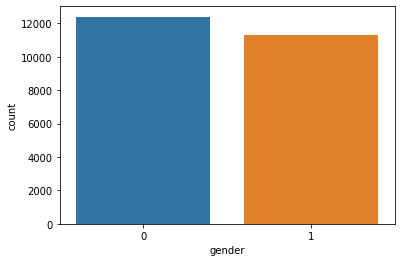

In [11]:
# Gender distribution
sns.countplot(x="gender", data=df)

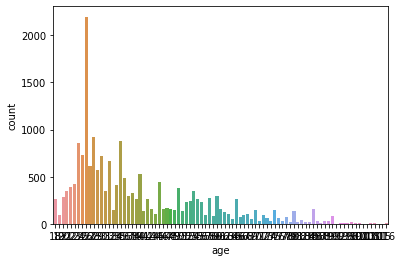

In [12]:
# Select only person who has age more than 18 
df = df[df.age >= 18]
df.reset_index(drop=True, inplace=True)

sns.countplot(x="age", data=df)

In [13]:
# Check null data
df.isnull().sum() 

age          0
ethnicity    0
gender       0
img_name     0
pixels       0
dtype: int64

In [14]:
# Input image configuration
num_pixels = len(df["pixels"][0].split(" "))
dimension = int(np.sqrt(num_pixels))
img_width = dimension
img_height = dimension

print("Pixels: {}".format(num_pixels))
print("Width: {0}, Height: {1}".format(img_width, img_height))

Pixels: 2304
Width: 48, Height: 48


In [15]:
X = df["pixels"]
y = df["gender"]

print(X.shape, y.shape)

(19472,) (19472,)


In [16]:
def str_to_pixels(string):
  arr = np.array(string.split(" "), dtype="uint8")
  return arr.reshape(img_width, img_height)

In [17]:
# Reshape X
X = np.array([str_to_pixels(string) for string in X])

print(X.shape)

(19472, 48, 48)


In [18]:
# Normalize X
X = X / 255.0

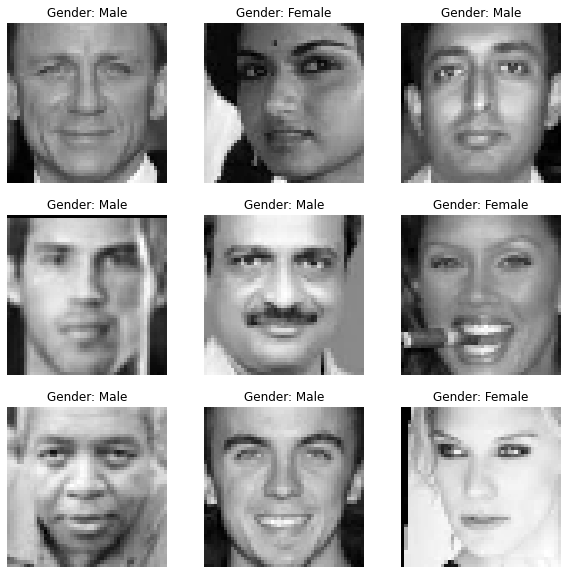

In [19]:
plt.figure(figsize=(10, 10))

i = 1

for index, image in random.choices(list(enumerate(X)), k=9):
  plt.subplot(3, 3, i)
  plt.axis("off")
  plt.title("Gender: {0}".format("Male" if y[index] == 0 else "Female"))
  i += 1
  plt.imshow(image, cmap="gray")
    
# Show the plot
plt.show()

In [20]:
# Use one hot encoding to transform the labels to data that the model can understand
y = to_categorical(y)

print(y.shape)

(19472, 2)


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X.reshape(X.shape[0], X.shape[1], X.shape[2], 1), y, train_size=0.8, random_state=42)

print(X_train.shape, y_train.shape)

(15577, 48, 48, 1) (15577, 2)


In [22]:
data_gen = ImageDataGenerator(
  rotation_range=30, # randomly rotate images in the range 5 degrees
  width_shift_range=0.1, # randomly shift images horizontally 10%
  height_shift_range=0.1, # randomly shift images vertically 10%
  zoom_range=0.2, # Randomly zoom image 20%
  horizontal_flip=True, # randomly flip images
  # vertical_flip=True # randomly flip images
)

data_gen.fit(X_train)

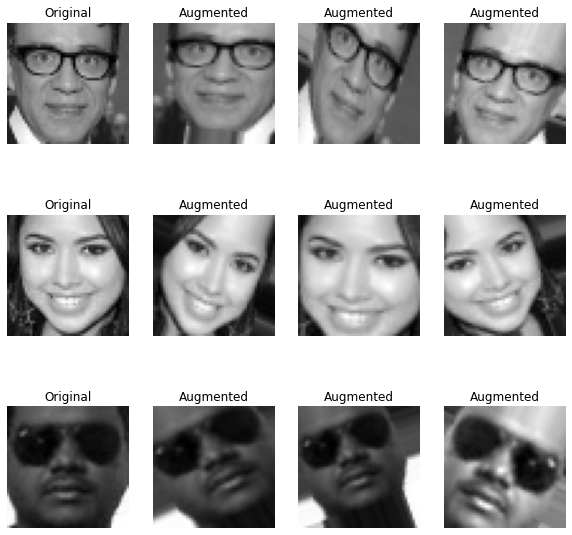

In [23]:
# Visualize the data augmentation
plt.figure(figsize=(10, 10))

i = 1

for image in random.choices(X_train, k=3):
  image_2d = image.reshape(48, 48)
  plt.subplot(3, 4, i)
  plt.axis("off")
  plt.title("Original")
  plt.imshow(image_2d, cmap="gray")

  i += 1

  for n in range(3):
    plt.subplot(3, 4, i)
    plt.axis("off")
    plt.title("Augmented")
    plt.imshow(data_gen.random_transform(image).reshape(48, 48), cmap="gray")
  
    i += 1

    
# Show the plot
plt.show()

In [63]:
model = Sequential()
  
model.add(Conv2D(64, kernel_size=(3,3), input_shape=(img_width, img_height, 1), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(128, kernel_size=(3,3), activation="relu", padding="same"))
model.add(Conv2D(128, kernel_size=(3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Conv2D(256, kernel_size=(3,3), activation="relu", padding="same"))
model.add(Conv2D(256, kernel_size=(3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Conv2D(512, kernel_size=(3,3), activation="relu", padding="same"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Flatten())

model.add(Dense(128, activation="relu"))
model.add(Dropout(0.3))

model.add(Dense(y_train.shape[1], activation="softmax"))

opt = Adam()

model.compile(
  loss="categorical_crossentropy",
  optimizer=opt,
  metrics=["accuracy"]
)

history = model.fit(
  data_gen.flow(X_train, y_train),
  epochs=50,
  batch_size=32,
  validation_data=(X_test, y_test)
)

Epoch 1/50
487/487 [==============================] - 14s 24ms/step - loss: 0.8893 - accuracy: 0.6294 - val_loss: 0.7381 - val_accuracy: 0.5820
Epoch 2/50
487/487 [==============================] - 11s 22ms/step - loss: 0.4387 - accuracy: 0.8072 - val_loss: 0.4754 - val_accuracy: 0.7710
Epoch 3/50
487/487 [==============================] - 11s 22ms/step - loss: 0.3599 - accuracy: 0.8503 - val_loss: 0.3173 - val_accuracy: 0.8745
Epoch 4/50
487/487 [==============================] - 11s 23ms/step - loss: 0.3398 - accuracy: 0.8570 - val_loss: 0.3271 - val_accuracy: 0.8578
Epoch 5/50
487/487 [==============================] - 11s 23ms/step - loss: 0.2961 - accuracy: 0.8806 - val_loss: 0.2532 - val_accuracy: 0.9004
Epoch 6/50
487/487 [==============================] - 11s 23ms/step - loss: 0.3029 - accuracy: 0.8818 - val_loss: 0.2275 - val_accuracy: 0.9199
Epoch 7/50
487/487 [==============================] - 11s 23ms/step - loss: 0.2645 - accuracy: 0.8941 - val_loss: 0.2603 - val_accuracy:

In [66]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_93 (Conv2D)           (None, 46, 46, 64)        640       
_________________________________________________________________
max_pooling2d_60 (MaxPooling (None, 23, 23, 64)        0         
_________________________________________________________________
batch_normalization_60 (Batc (None, 23, 23, 64)        256       
_________________________________________________________________
conv2d_94 (Conv2D)           (None, 23, 23, 128)       73856     
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 21, 21, 128)       147584    
_________________________________________________________________
max_pooling2d_61 (MaxPooling (None, 10, 10, 128)       0         
_________________________________________________________________
dropout_52 (Dropout)         (None, 10, 10, 128)     

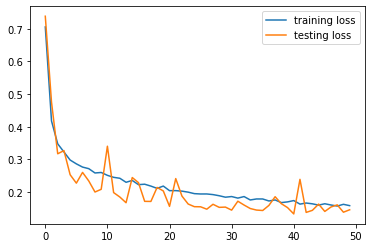

In [67]:
plt.plot(history.history["loss"], label="training loss")
plt.plot(history.history["val_loss"], label="testing loss")
plt.legend();

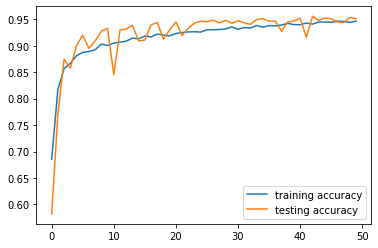

In [68]:
plt.plot(history.history["accuracy"], label="training accuracy")
plt.plot(history.history["val_accuracy"], label="testing accuracy")
plt.legend();

In [69]:
model.evaluate(X_test, y_test)

122/122 [==============================] - 1s 7ms/step - loss: 0.1460 - accuracy: 0.9515


[0.14600925147533417, 0.9514762759208679]

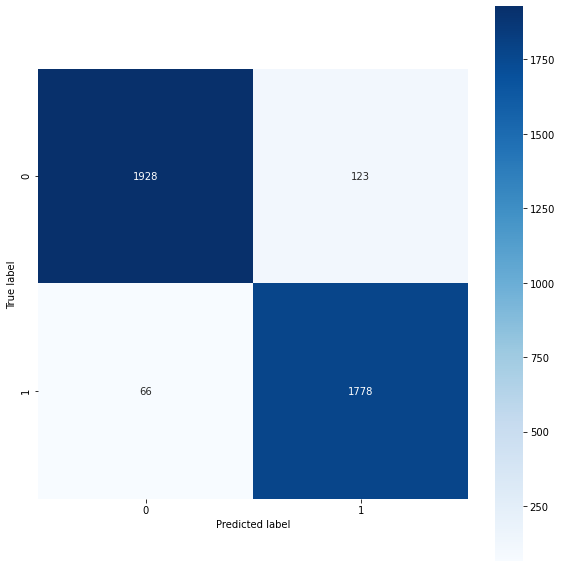

In [70]:
y_pred = np.argmax(model.predict(X_test), axis=-1)

y_test_round = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_test_round, y_pred)

figure = plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, cmap=plt.cm.Blues, square=True, fmt="")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.show()

In [71]:
print("Precision:", precision_score(y_test_round, y_pred))
print("Recall:", recall_score(y_test_round, y_pred))
print("F1 score:", f1_score(y_test_round,y_pred))

Precision: 0.9352972119936875
Recall: 0.9642082429501084
F1 score: 0.9495327102803739


In [72]:
model.save("model")

INFO:tensorflow:Assets written to: model/assets


In [73]:
!zip -r /content/model.zip /content/model

  adding: content/model/ (stored 0%)
  adding: content/model/variables/ (stored 0%)
  adding: content/model/variables/variables.index (deflated 73%)
  adding: content/model/variables/variables.data-00000-of-00001 (deflated 9%)
  adding: content/model/assets/ (stored 0%)
  adding: content/model/keras_metadata.pb (deflated 94%)
  adding: content/model/saved_model.pb (deflated 90%)
